# ResNet

# 1번_웜:쿨 비율 동일하게 
warm_1 238장 + cool_1 238장 "총 476장" 

In [ ]:
# 1-1-1

## batch_size=16, epochs=30, learning rate=0.0001(네번째자리)

## (1) 라이브러리 및 데이터 불러오기

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import vgg16

import numpy as np
import cv2
import os
import glob
from PIL import Image

## 데이터 불러오고, 웜톤 0, 쿨톤 1로 레이블링

In [2]:
import random

In [3]:
def load_data(img_path, number_of_data=476):  # warm_1 238 + cool_1 238
    # 웜톤 : 0, 쿨톤 : 1
    img_size=224
    color=3
    #이미지 데이터와 라벨(웜톤 : 0, 쿨톤 : 1) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    warm_files = list(glob.iglob(img_path + '/warm_1/*.jpg')) + list(glob.iglob(img_path + '/warm_1/*.JPG'))     
    # 리스트에서 무작위로 238개 선택
    warm_files = random.sample(warm_files, 238)
    for file in warm_files:
        img = Image.open(file)  # 이미지 열기
        img = img.resize((img_size, img_size))  # 이미지 크기 조정
        img = np.array(img, dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 웜톤 : 0
        idx=idx+1

    cool_files = list(glob.iglob(img_path + '/cool_1/*.jpg')) + list(glob.iglob(img_path + '/cool_1/*.JPG')) 
    for file in cool_files:
        img = Image.open(file)  # 이미지 열기
        img = img.resize((img_size, img_size))  # 이미지 크기 조정
        img = np.array(img, dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 쿨톤 : 1
        idx=idx+1  
    
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/project/first-repository/aiffelthon/content/drive/MyDrive/사계절_연예인 이미지 데이터셋/train data"
(x_train, y_train)=load_data(image_dir_path)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 476 입니다.
x_train shape: (476, 224, 224, 3)
y_train shape: (476,)


## 정규화

In [4]:
x_train = x_train / 255.0

## (3) train, val 분리하기

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.3,
                                                  random_state=42)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


In [39]:
# 1-1-2

## 정규화, random_state=42, batch_size=16, epochs=50, learning rate=0.0001(네번째자리),

## 데이터 바로 사용해도 되는지 확인

In [40]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (333, 224, 224, 3)
y_train:  (333,)
x_val:  (143, 224, 224, 3)
y_val:  (143,)


## (4) 모델 정의 및 컴파일

In [8]:
# ResNet-50 모델 불러오기
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(resnet50.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=resnet50.input, outputs=output)

94781440/94765736 [==============================] - 0s 0us/step


In [9]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [10]:
# early stopping, checkpoint
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    './check/ResNet/1번/1-2-2/model_{epoch:02d}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',    
)

## (5) 모델 학습하기

In [11]:
# early stopping과 checkpoint가 적용된 model.fit
history = model.fit(
    x_train, y_train, 
    batch_size=16, 
    epochs=50, 
    validation_data=(x_val, y_val), 
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/50
21/21 [==============================] - 56s 338ms/step - loss: 0.4542 - accuracy: 0.7838 - val_loss: 0.7687 - val_accuracy: 0.5245

Epoch 00001: val_loss improved from inf to 0.76870, saving model to ./check/ResNet/1번/1-2-2/model_01.h5


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
21/21 [==============================] - 4s 184ms/step - loss: 0.1005 - accuracy: 0.9640 - val_loss: 0.8372 - val_accuracy: 0.5245

Epoch 00002: val_loss did not improve from 0.76870
Epoch 3/50
21/21 [==============================] - 4s 185ms/step - loss: 0.0378 - accuracy: 0.9850 - val_loss: 0.9510 - val_accuracy: 0.5245

Epoch 00003: val_loss did not improve from 0.76870
Epoch 4/50
21/21 [==============================] - 4s 186ms/step - loss: 0.0290 - accuracy: 0.9880 - val_loss: 1.1017 - val_accuracy: 0.5245

Epoch 00004: val_loss did not improve from 0.76870
Epoch 5/50
21/21 [==============================] - 4s 185ms/step - loss: 0.0150 - accuracy: 0.9940 - val_loss: 1.1654 - val_accuracy: 0.5245

Epoch 00005: val_loss did not improve from 0.76870
Epoch 6/50
21/21 [==============================] - 4s 185ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 2.4738 - val_accuracy: 0.5245

Epoch 00006: val_loss did not improve from 0.76870
Epoch 7/50
21/21 [============

## (6) 예측하기

In [12]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [13]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0]
[[0.7009481  0.29905188]
 [0.7132241  0.2867759 ]
 [0.7141526  0.28584743]
 [0.7096471  0.29035288]
 [0.7150188  0.2849812 ]
 [0.7057851  0.2942149 ]
 [0.70950824 0.29049176]
 [0.71261406 0.28738594]
 [0.7056262  0.2943738 ]
 [0.7118828  0.28811717]
 [0.6976975  0.30230245]
 [0.7112481  0.28875193]
 [0.70720625 0.29279378]
 [0.7172737  0.28272623]
 [0.7092413  0.29075876]
 [0.7147102  0.28528976]
 [0.70673764 0.293

In [14]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.524476


## loss, accuracy 시각화

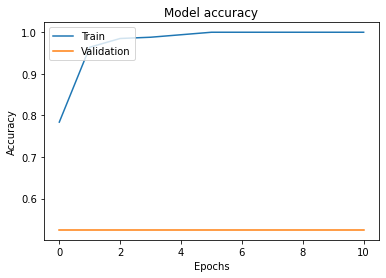

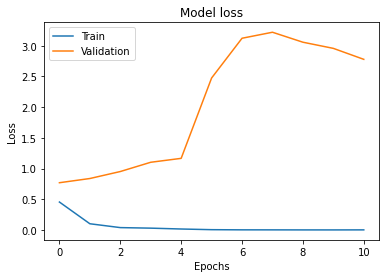

In [15]:
import matplotlib.pyplot as plt

# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

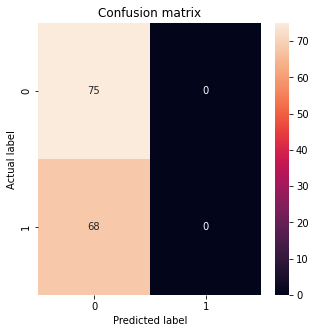

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.52      1.00      0.69        75
           1       0.00      0.00      0.00        68

    accuracy                           0.52       143
   macro avg       0.26      0.50      0.34       143
weighted avg       0.28      0.52      0.36       143



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
